In [394]:
import psycopg2
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
from lxml import etree
import os
import re
import numpy as np
import html5lib
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

def apply_regex(regex, string):
    match = re.search(regex, string)
    if match:
        return match.group()
    else:
        return np.nan

def scrape_to_df(url: str, multilevel=False):
    res = requests.get(url)
    if res.ok:
        soup = bs(res.content, "html.parser")
        table = soup.find("table", {"id": "data"})
        df = pd.read_html(str(table))[0]
    else:
        print("oops something didn't work right", res.status_code)
    if multilevel:
        df.columns = df.columns.droplevel(
            level=0
        )
    return df

In [10]:
while True:
    try:
        conn = psycopg2.connect(
            "dbname=thefantasybot user=tbakely"
        )
        cursor = conn.cursor()
        print("Connection successful.")
        break
    except Exception as error:
        print("Connection failed.")
        print("Error: ", error)

Connection successful.


In [11]:
import os
import pandas as pd

os.path.abspath('.')

'/Users/tylerbakely/Desktop/repos/thefantasybot/root/backend/app'

In [12]:
parent_dir = os.path.abspath(".")
df = pd.read_json(os.path.join(parent_dir, "data/draftboard_standard.json"))

In [13]:
df.head()

,PLAYER,POS,VOR Rank,ADP Rank,Sleeper Score
0,Jonathan Taylor,RB,1,1,0
1,Derrick Henry,RB,2,4,2
2,Cooper Kupp,WR,3,6,3
3,Christian McCaffrey,RB,4,2,-2
4,Ja'Marr Chase,WR,5,10,5


In [14]:
os.path.join(parent_dir, "data/draftboard_standard.json")

'/Users/tylerbakely/Desktop/repos/thefantasybot/root/backend/app/data/draftboard_standard.json'

In [15]:
os.path.join(parent_dir, 'data/draftboard_standard.json')

'/Users/tylerbakely/Desktop/repos/thefantasybot/root/backend/app/data/draftboard_standard.json'

In [16]:
import json

file_path = (
    "/Users/tylerbakely/Desktop/repos/thefantasybot/root/backend/app/data/"
)
with open(os.path.join(file_path, "draftboard_standard.json"), "r") as f:
    data = json.load(f)

In [17]:
data[0]['PLAYER']

'Jonathan Taylor'

In [66]:
def scrape_to_df(url: str, multilevel=False):
    res = requests.get(url)
    if res.ok:
        soup = bs(res.content, "html.parser")
        table = soup.find("table", {"id": "data"})
        df = pd.read_html(str(table))[0]
    else:
        print("oops something didn't work right", res.status_code)
    if multilevel:
        df.columns = df.columns.droplevel(
            level=0
        )
    return df

In [421]:
# Projected Fantasy Points
def projected_points(scoring: str = 'STD', week: str = 'draft'):
    """Scrapes projected points from fantasypros.com

    Args:
        scoring (str, optional): 'STD', 'PPR', or 'HALF'. Defaults to 'STD'.
        week (str, optional): _description_. Defaults to 'draft'.

    Returns:
        pd.DataFrame: Finalized dataframe with projected points for the week.
    """
    data = []
    for position in ['qb', 'wr', 'rb', 'te']:
        df = scrape_to_df(f"https://www.fantasypros.com/nfl/projections/{position}.php?week={week}&scoring={scoring}", multilevel=True)
        df['Team'] = df['Player'].apply(lambda x: apply_regex(r'(?!IV|I{1,3})([A-Z]{2,3})', x))
        df['Player'] = df['Player'].apply(lambda x: apply_regex(r"^([a-zA-Z'-.]+\s[a-zA-Z'-]+)(\s(IV|I{2,3}))?", x))
        df['Position'] = position.upper()
        df = df[['Player', 'Position', 'Team', 'FPTS']]
        data.append(df)
    data = pd.concat(data)

    data = data.sort_values('FPTS', ascending=False).reset_index(drop=True)

    return data

In [422]:
def tiering_players_all(scoring: str = 'STD'):

    def tiering_players_pos(scoring: str = 'STD', pos: str = "RB"):
        
        tier_num_mapping = {
            "QB": 8,
            "RB": 11,
            "WR": 12,
            "TE": 9,
        }

        proj_points = projected_points(scoring)
        training = proj_points.loc[proj_points['Position'] == pos]

        gm = GaussianMixture(n_components=tier_num_mapping[pos], random_state=0)
        training['gmm_labels'] = gm.fit_predict(training[['FPTS']])

        tier_map = {}

        testlist = training['gmm_labels'].tolist()
        count = 1
        for num in testlist:
            if num not in tier_map:
                tier_map[num] = count
                count += 1

        training['Tier'] = training['gmm_labels'].map(tier_map)
        training.drop('gmm_labels', axis=1, inplace=True)
        training.reset_index(drop=True, inplace=True)

        return training
        
    df_list = []
    for position in ["QB", "RB", "WR", "TE"]:
        temp = tiering_players_pos(scoring=scoring, pos=position)
        df_list.append(temp)

    df = pd.concat(df_list)
    df.reset_index(drop=True, inplace=True)
    df = df[['Player', 'Tier']]

    return df

In [20]:
# ADP
def pull_adp(scoring: str = 'STD'):
    scoring_map = {
        'STD': 'overall',
        'PPR': 'ppr-overall',
        'HALF': 'half-point-ppr-overall'
    }

    df = scrape_to_df(f"https://www.fantasypros.com/nfl/adp/{scoring_map[scoring]}.php")
    df['Player'] = df['Player Team (Bye)'].apply(lambda x: apply_regex(r"^([a-zA-Z'-.]+\s[a-zA-Z'-]+)(\s(IV|I{2,3}))?", x))
    df['Team'] = df['Player Team (Bye)'].apply(lambda x: apply_regex(r'(?!IV|I{1,3})([A-Z]{2,3})', x))
    df['Bye'] = df['Player Team (Bye)'].apply(lambda x: apply_regex(r'\d+', x))
    df['Position'] = df['POS'].apply(lambda x: apply_regex(r'\D+', x))
    df.rename(columns={'AVG': 'ADP'}, inplace=True)

    df = df[['Rank', 'Player', 'Team', 'Bye', 'Position', 'ADP']]
    return df

In [21]:
regex = r"(\w+\s+)(\w+)"
string = "Christian McCaffrey SF (9)"

re.match(regex, string).group()

'Christian McCaffrey'

In [22]:
df['Player'] = df['Player Team (Bye)'].apply(lambda x: apply_regex(r"(\w+\s+)(\w+)", x))
df['Team'] = df['Player Team (Bye)'].apply(lambda x: apply_regex(r'[A-Z]{2,}$', x))
df['Bye'] = df['Player Team (Bye)'].apply(lambda x: apply_regex(r'\d+', x))
df['Position'] = df['POS'].apply(lambda x: apply_regex(r'\D+', x))
df.rename(columns={'AVG': 'ADP'}, inplace=True)

KeyError: 'Player Team (Bye)'

In [ ]:
df[['Rank', 'Player', 'Team', 'Bye', 'Position', 'ADP']].head()

,Rank,Player,Team,Bye,Position,ADP
0,1,Jonathan Taylor,IND,14,RB,1.0
1,2,Christian McCaffrey,SF,9,RB,2.5
2,3,Austin Ekeler,LAC,8,RB,3.5
3,4,Derrick Henry,TEN,6,RB,5.0
4,5,Dalvin Cook,MIN,7,RB,6.0


In [24]:
df.tail(30)

,PLAYER,POS,VOR Rank,ADP Rank,Sleeper Score
127,Jalen Tolbert,WR,135,154,19
128,Tua Tagovailoa,QB,138,118,-20
129,Rondale Moore,WR,139,141,2
130,Joshua Palmer,WR,140,151,11
131,Skyy Moore,WR,143,113,-30
132,Michael Carter,RB,144,107,-37
133,Alec Pierce,WR,145,152,7
134,Raheem Mostert,RB,148,124,-24
135,James Robinson,RB,149,101,-48
136,Ryan Tannehill,QB,151,148,-3


In [25]:
df = projected_points()

UnboundLocalError: cannot access local variable 'result' where it is not associated with a value

In [423]:
def get_draft_board(scoring: str = 'STD'):

    replacement_players = {"QB": "", "RB": "", "WR": "", "TE": ""}

    adp_df = pull_adp(scoring)

    projections = projected_points(scoring)
    
    cutoff = 95
    adp_df_cutoff = adp_df[:cutoff]

    
    for _, row in adp_df_cutoff.iterrows():
        position = row["Position"]
        player = row["Player"]

        if position in replacement_players:
            replacement_players[position] = player

    replacement_values = {}

    for position, player_name in replacement_players.items():
        player = projections.loc[projections.Player == player_name]
        replacement_values[position] = player["FPTS"].tolist()[0]

    projections = projections.loc[projections.Position.isin(["QB", "RB", "WR", "TE"])]
    projections["VOR"] = projections.apply(
        lambda row: row["FPTS"] - replacement_values.get(row["Position"]), axis=1
    )
    projections["VOR Rank"] = projections["VOR"].rank(ascending=False).astype(int)
    projections = projections.sort_values("VOR", ascending=False)

    complete_df = projections.merge(adp_df, how="left", on=["Player", "Position"])[
        :200
    ].dropna()
    complete_df["ADP Rank"] = complete_df["ADP"].rank().astype(int)
    complete_df["Sleeper Score"] = complete_df["ADP Rank"] - complete_df["VOR Rank"]
    complete_df = complete_df[
        ["Player", "Position", "VOR Rank", "ADP Rank", "Sleeper Score"]
    ]

    player_tiers = tiering_players_all(scoring)

    complete_df = pd.merge(complete_df, player_tiers, how="left", on="Player")

    return complete_df

In [425]:
get_draft_board("HALF")

,Player,Position,VOR Rank,ADP Rank,Sleeper Score,Tier
0,Jonathan Taylor,RB,1,1,0,1
1,Cooper Kupp,WR,2,4,2,1
2,Christian McCaffrey,RB,3,2,-1,1
3,Derrick Henry,RB,4,4,0,2
4,Austin Ekeler,RB,5,3,-2,2
...,...,...,...,...,...,...
171,Jameson Williams,WR,188,159,-29,8
172,Rachaad White,RB,192,132,-60,7
173,Baker Mayfield,QB,193,136,-57,4
174,Khalil Herbert,RB,197,134,-63,7


In [186]:
score_system = input('Enter the scoring system: STD, PPR, or HALF')
get_draft_board(score_system)

,Player,Position,VOR Rank,ADP Rank,Sleeper Score
0,Jonathan Taylor,RB,1,1,0
1,Derrick Henry,RB,2,4,2
2,Christian McCaffrey,RB,3,2,-1
3,Austin Ekeler,RB,4,3,-1
4,Joe Mixon,RB,5,9,4
...,...,...,...,...,...
190,Chuba Hubbard,RB,191,160,-31
192,Jameis Winston,QB,193,130,-63
194,Zay Jones,WR,195,186,-9
195,Mac Jones,QB,196,146,-50


In [50]:
df = scrape_to_df(f"https://www.fantasypros.com/nfl/adp/overall.php")

In [36]:
df['Player'] = df['Player Team (Bye)'].apply(lambda x: apply_regex(r"^([a-zA-Z'-.]+\s[a-zA-Z'-]+)(\s(IV|I{2,3}))?", x))

In [418]:
tiering_players_all().sort_values('Tier')

,Player,Position,Team,Tier
0,Josh Allen,QB,BUF,1
208,Justin Jefferson,WR,MIN,1
209,Deebo Samuel,WR,SF,1
210,Davante Adams,WR,LV,1
207,Ja'Marr Chase,WR,CIN,1
...,...,...,...,...
405,Jared Bernhardt,WR,ATL,12
406,Easop Winston,WR,SEA,12
407,Dax Milne,WR,WAS,12
399,Willie Snead IV,WR,SF,12


In [112]:
res = requests.get("https://www.fantasypros.com/nfl/rankings/half-point-ppr-cheatsheets.php")
if res.ok:
    soup = bs(res.content, "html.parser")
    table = soup.find("table")
    read = etree.HTML(str(soup))
    # df = pd.read_html(str(table))[0]

In [130]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By

url = 'https://www.fantasypros.com/nfl/rankings/consensus-cheatsheets.php'

driver = webdriver.Firefox()
driver.get(url)
try:
    element = driver.find_element(By.ID, "ranking-table")
    element_html = element.get_attribute("outerHTML")
finally:
    driver.quit()

In [136]:
df = pd.read_html(element_html)[0]
df.dropna(subset='Player Name', inplace=True)
df.head(20)

,RK,WSID,Player Name,POS,BEST,WORST,AVG.,STD.DEV,ECR VS. ADP
1,1,NaN,Christian McCaffrey (SF),RB1,1.0,8.0,1.5,1.3,-
2,2,NaN,Jonathan Taylor (IND),RB2,2.0,9.0,3.7,1.7,-
3,3,NaN,Bijan Robinson (ATL),RB3,1.0,19.0,4.1,3.9,-
4,4,NaN,Austin Ekeler (LAC),RB4,3.0,21.0,4.3,3.2,-
5,5,NaN,Saquon Barkley (NYG),RB5,2.0,9.0,4.5,1.6,-
7,6,NaN,Josh Jacobs (LV),RB6,4.0,51.0,8.8,8.1,-
8,7,NaN,Tony Pollard (DAL),RB7,5.0,19.0,9.1,3.2,-
9,8,NaN,Nick Chubb (CLE),RB8,4.0,26.0,9.6,4.2,-
10,9,NaN,Derrick Henry (TEN),RB9,3.0,26.0,9.8,4.8,-
11,10,NaN,Justin Jefferson (MIN),WR1,4.0,12.0,9.9,1.4,-


In [183]:
df = scrape_to_df("https://www.fantasypros.com/nfl/red-zone-stats/rb.php?week=1&range=week", multilevel=False)
df.columns = ['_'.join(col) for col in df.columns.values]
df.columns = [re.search(r"([a-zA-Z]+)$", col).group() if ':' in col else col for col in df.columns]

In [184]:
test['Targets'] = test['RUSHING_ATT'] + test['RECEIVING_TGT']
test['TDs'] = test['RUSHING_TD'] + test['RECEIVING_TD']
test['Team'] = test['Player'].apply(lambda x: apply_regex(r'[A-Z]{2,}', x))
test['Player'] = test['Player'].apply(lambda x: apply_regex(r"^([a-zA-Z'-.]+\s[a-zA-Z'-]+)(\s(IV|I{2,3}))?", x))
test = test[['Player', 'Team', 'Targets', 'TDs']].sort_values(['Targets', 'TDs'], ascending=False).reset_index(drop=True)
test.head()

,Player,Team,Targets,TDs
0,Jamaal Williams,NO,7,2
1,Jonathan Taylor,IND,7,1
2,Saquon Barkley,NYG,6,1
3,Kareem Hunt,FA,5,1
4,Christian McCaffrey,SF,4,1


In [277]:
def redzone_targets(position: str,
                    yardline: int = 20,
                    weekly: bool = False,
                    week: int = 1,                  
                    ):
    if weekly:
        url = f"https://www.fantasypros.com/nfl/red-zone-stats/{position.lower()}.php?week={week}&range=week&yardline={yardline}"
    else:
        url = f"https://www.fantasypros.com/nfl/red-zone-stats/{position.lower()}.php?range=full&yardline={yardline}"
    df = scrape_to_df(url)
    df.columns = ['_'.join(col) for col in df.columns.values]
    df.columns = [re.search(r"([a-zA-Z]+)$", col).group() if ':' in col else col for col in df.columns]
    
    df['Redzone'] = f'Inside {yardline}'
    df['Targets'] = df['RUSHING_ATT'] + df['RECEIVING_TGT']
    df['TD'] = df['RUSHING_TD'] + df['RECEIVING_TD']
    df['Team'] = df['Player'].apply(lambda x: apply_regex(r'[A-Z]{2,}', x))
    df['Player'] = df['Player'].apply(lambda x: apply_regex(r"^([a-zA-Z'-.]+\s[a-zA-Z'-]+)(\s(IV|I{2,3}))?", x))
    if weekly:
        df['Week'] = f'Week {week}'
        df = df[['Player', 'Team', 'Week', 'Redzone', 'Targets', 'TD']].sort_values(['Targets'], ascending=False).reset_index(drop=True)
    else:
        df = df[['Redzone', 'Player', 'Team', 'Week', 'Targets', 'TD']].sort_values(['Targets'], ascending=False).reset_index(drop=True)

    return df

In [316]:
def weekly_change_report(pos: str, curr_week: int, prior_week: int, yardline: int = 20, sort_on_targets=True):
    df = redzone_targets(pos, weekly=True, week=prior_week, yardline=yardline)
    df2 = redzone_targets(pos, weekly=True, week=curr_week, yardline=yardline)

    comparison = pd.merge(df2, df, how="inner", on=["Player"])
    comparison['% Change in Targets'] = round((((comparison['Targets_x'] - comparison['Targets_y']) / comparison['Targets_y']) * 100), 2)
    comparison.drop(['Team_y', 'Week_y', 'Redzone_y'], axis=1, inplace=True)
    comparison.rename(columns={
        'Team_x': 'Team',
        'Targets_x': 'Targets',
        'TD_x': 'TD',
        'Targets_y': 'Targets Prior',
        'TD_y': 'TD Prior',
        'Week_x': 'Week',
        'Redzone_x': 'Redzone'
    }, inplace=True)
    # comparison.columns = [re.sub(r"_x", r"", col) for col in comparison.columns]
    if sort_on_targets:
        comparison = comparison.sort_values('Targets', ascending=False)
        comparison['% Change in Targets'] = comparison['% Change in Targets'].astype(str) + '%'
    else:
        comparison = comparison.sort_values('% Change in Targets', ascending=False)
        comparison['% Change in Targets'] = comparison['% Change in Targets'].astype(str) + '%'
    
    return comparison

In [317]:
# def total_redzone_targets(pos: str, weekly=True, week = 1):
#     redzone_list = []
#     for yardline in np.arange(5, 25, 5):
#         if weekly:
#             df = redzone_targets(pos, weekly=True, week=week, yardline=yardline)
#         else:
#             df = redzone_targets(pos, weekly=False, yardline=yardline)
        
#         redzone_list.append(df)
#     temp_df = pd.concat(redzone_list)
#     if weekly:
#         final_df = temp_df.groupby(['Player', 'Team', 'Week'], as_index=False).sum(['Targets', 'TD'])
#         final_df = final_df.sort_values('Targets', ascending=False)
#     else:
#         final_df = temp_df.groupby(['Player', 'Team'], as_index=False).sum(['Targets', 'TD'])
#         final_df = final_df.sort_values('Targets', ascending=False)
#         final_df.reset_index(drop=True, inplace=True)

#     return final_df


In [321]:
weekly_change_report("RB", 7, 6, sort_on_targets=True)

,Player,Team,Week,Redzone,Targets,TD,Targets Prior,TD Prior,% Change in Targets
0,Joe Mixon,CIN,Week 7,Inside 20,7,1,2,1,250.0%
2,Eno Benjamin,NO,Week 7,Inside 20,6,1,1,0,500.0%
1,Kenneth Walker III,III,Week 7,Inside 20,6,1,5,1,20.0%
3,Tyler Allgeier,ATL,Week 7,Inside 20,5,1,2,0,150.0%
4,Saquon Barkley,NYG,Week 7,Inside 20,5,0,7,1,-28.57%
5,Keaontay Ingram,ARI,Week 7,Inside 20,5,1,1,0,400.0%
6,Brian Robinson,WAS,Week 7,Inside 20,5,0,4,1,25.0%
7,Travis Etienne,JAC,Week 7,Inside 20,5,1,2,0,150.0%
8,Nick Chubb,CLE,Week 7,Inside 20,4,1,1,0,300.0%
9,Alvin Kamara,NO,Week 7,Inside 20,4,0,6,0,-33.33%


In [327]:
proj_points = projected_points('STD')
training = proj_points.loc[proj_points['Position'] == 'RB']

In [329]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

kmeans = KMeans(8, random_state=0)
training['labels'] = kmeans.fit_predict(training[['FPTS']])


/Users/tylerbakely/Desktop/repos/thefantasybot/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/kd/wsb4g4vj6gx4yk1tp4zdh_h00000gn/T/ipykernel_99017/1094378657.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['labels'] = kmeans.fit_predict(training[['FPTS']])


Text(0.5, 1.0, 'RB Tiers for 2023 Fantasy Draft')

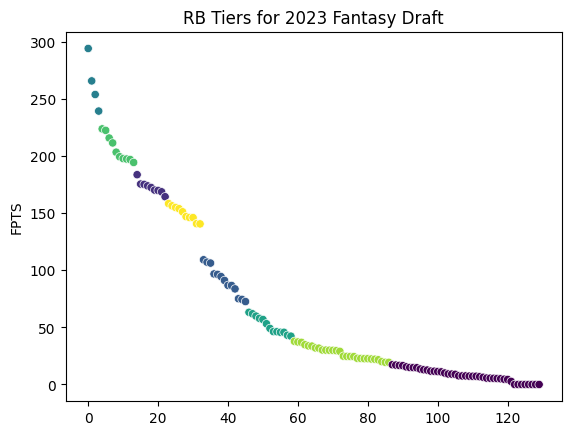

In [338]:
sns.scatterplot(x=range(training.shape[0]), y=training['FPTS'], c=training['labels'])
plt.title("RB Tiers for 2023 Fantasy Draft")

In [353]:
training.head(20)

,Player,Position,Team,FPTS,labels,gmm_labels
14,Jonathan Taylor,RB,ND,294.2,3,4
19,Derrick Henry,RB,TEN,265.8,3,7
23,Christian McCaffrey,RB,SF,253.9,3,7
26,Austin Ekeler,RB,LAC,239.4,3,7
29,Joe Mixon,RB,CIN,223.8,5,1
30,Alvin Kamara,RB,NO,222.5,5,1
31,Dalvin Cook,RB,MIN,215.8,5,1
33,Najee Harris,RB,PIT,211.5,5,1
37,Aaron Jones,RB,GB,203.4,5,1
39,James Conner,RB,ARI,199.4,5,1


In [352]:
from sklearn.mixture import GaussianMixture

bgm = GaussianMixture(n_components=11, random_state=0)
training['gmm_labels'] = bgm.fit_predict(training[['FPTS']])

/var/folders/kd/wsb4g4vj6gx4yk1tp4zdh_h00000gn/T/ipykernel_99017/485476425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['gmm_labels'] = bgm.fit_predict(training[['FPTS']])


Text(0.5, 1.0, 'RB Tiers for 2023 Fantasy Draft - GMM')

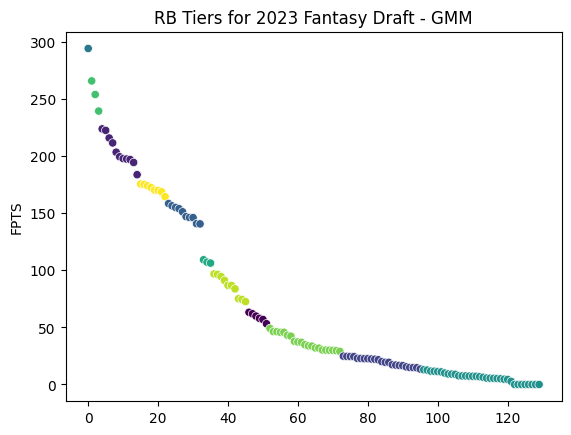

In [350]:
sns.scatterplot(x=range(training.shape[0]), y=training['FPTS'], c=training['gmm_labels'])
plt.title("RB Tiers for 2023 Fantasy Draft - GMM")

In [347]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 20),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(training[['FPTS']])

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 20)},
             scoring=<function gmm_bic_score at 0x2aab91f80>)

In [348]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head(20)

,Number of components,Type of covariance,BIC score
0,1,spherical,373.710824
38,1,diag,373.710824
19,1,tied,373.710824
57,1,full,373.710824
1,2,spherical,391.622842
39,2,diag,391.622842
58,2,full,391.622842
59,3,full,427.736786
20,2,tied,428.552909
2,3,spherical,432.220673


In [354]:
tier_num_mapping = {
    "QB": 8,
    "RB": 11,
    "WR": 12,
    "TE": 9,
}

pos = "RB"

proj_points = projected_points('STD')
training = proj_points.loc[proj_points['Position'] == 'RB']

bgm = GaussianMixture(n_components=tier_num_mapping[pos], random_state=0)
training['gmm_labels'] = bgm.fit_predict(training[['FPTS']])

/var/folders/kd/wsb4g4vj6gx4yk1tp4zdh_h00000gn/T/ipykernel_99017/913947375.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['gmm_labels'] = bgm.fit_predict(training[['FPTS']])


Text(0.5, 1.0, 'RB Tiers for 2023 Fantasy Draft - GMM')

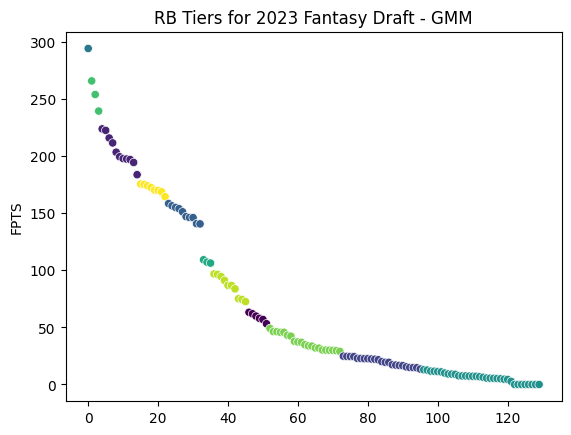

In [355]:
sns.scatterplot(x=range(training.shape[0]), y=training['FPTS'], c=training['gmm_labels'])
plt.title("RB Tiers for 2023 Fantasy Draft - GMM")

In [374]:
# # training.head(20)
# def tiering(label):
#     if label.lag() == np.nan:
#         return 0
#     elif label.lead() == np.nan:
#         return label.lag()
#     elif label != label.lag():
#         return label.lag() + 1
#     else:
#         return label.lag()

    
# training['gmm_labels_lag'] = training['gmm_labels'].lag()
# training['gmm_labels_lead'] = training['gmm_labels'].lead()
# training['gmm_relabeled'] = np.where(training['gmm_label_lag'] == np.nan, 0,
#                                  np.where(training['gmm_labels_lead'] == np.nan, training['gmm_labels_lag'],
#                                     np.where(training['gmm_labels'] != training['gmm_labels'].lag(), training['gmm_labels'].lag() + 1, training['gmm_labels'].lag())))

In [390]:
tier_map = {}
testlist = training['gmm_labels'].tolist()
count = 0
for num in testlist:
    if num not in tier_map:
        tier_map[num] = count
        count += 1

In [391]:
training['gmm_relabeled'] = training['gmm_labels'].map(tier_map)

In [445]:
training.head(20)

,Player,Position,Team,FPTS,gmm_labels,gmm_relabeled
14,Jonathan Taylor,RB,ND,294.2,4,0
19,Derrick Henry,RB,TEN,265.8,7,1
23,Christian McCaffrey,RB,SF,253.9,7,1
26,Austin Ekeler,RB,LAC,239.4,7,1
29,Joe Mixon,RB,CIN,223.8,1,2
30,Alvin Kamara,RB,NO,222.5,1,2
31,Dalvin Cook,RB,MIN,215.8,1,2
33,Najee Harris,RB,PIT,211.5,1,2
37,Aaron Jones,RB,GB,203.4,1,2
39,James Conner,RB,ARI,199.4,1,2


In [450]:
def snake_picks(number_of_teams = 12, rounds = 16):
    all_picks = {}
    for draft_position in range(1, 13):
        picks = []
        for round_no in range(1, rounds + 1):
            if round_no % 2 == 0:
                draft_pick = (round_no * number_of_teams) - draft_position + 1
            else:
                draft_pick = ((round_no - 1) * number_of_teams) + draft_position
            picks.append(draft_pick)
        all_picks[draft_position] = picks

    return all_picks

In [456]:
snake_pick = snake_picks()
for k, v in snake_pick.items():
    if 134 in v:
        print(k)

11


In [462]:
currentDrafter = [k for k, v in snake_pick.items() if 134 in v]

In [464]:
test1 = [
  {
    "id": 0,
    "player": "Jonathan Taylor",
    "position": "RB",
    "value_score": 1,
    "adp": 1,
    "sleeper_score": 0,
    "tier": 1,
    "drafted": False
  },
  {
    "id": 1,
    "player": "Derrick Henry",
    "position": "RB",
    "value_score": 2,
    "adp": 4,
    "sleeper_score": 2,
    "tier": 2,
    "drafted": False
  },
  {
    "id": 2,
    "player": "Christian McCaffrey",
    "position": "RB",
    "value_score": 3,
    "adp": 2,
    "sleeper_score": -1,
    "tier": 2,
    "drafted": False
  }
]

test2 = [
  {
    "id": 0,
    "player": "Jonathan Taylor",
    "position": "RB",
    "value_score": 1,
    "adp": 1,
    "sleeper_score": 0,
    "tier": 1,
    "drafted": False
  }
]

In [475]:
ids1 = [player["id"] for player in test1]
ids2 = [player["id"] for player in test2]

In [477]:
list(set(ids1) - set(ids2))

[1, 2]